# Exercise 10 :
# Markovian Langevin Dynamics

* Léa Beaules
* 28 January 2021

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random
import copy
import numpy as np
import scipy as scy
from tqdm.notebook import trange, tqdm
import time 
from scipy.stats import maxwell

#used for the video
import subprocess
import glob
import os

## Introduction 

We simulate 50 particles in a box (5nmx5nm) with periodic boundary condictions. The particules interact with each other via the lLennard-Jones potential and the velocities and positions are calculated with the Velocity Verlet integrator and van der Waals forces. Because this type of simulations causes the artificial generation of excess heat we add in the simulation the Berendsen thermostat, which keeps the total energy of the system constant instead of artificially increasing. In the last exercice we calculated the autocorrelation function as well as the Stokes friction coefficient.

The specificity of this simulation is that out of the 50 particles, two of them (1st and 50th) are bound to each other in such a way that their distance in constant over time. They will start with an initial velocity = 0, and at each time step we cancel out the contibution of the force along their connecting vector (by appliying a "Constraint force").

We will finally calculate the Free energy of thoses two particles and compare it the their potential energy. And similarly to the last exercice we calculate the constraint force autocorrelation function as well as the Stokes friction coefficient. And compare them to previous results.


## Task I: Implementation of Markovian Langevin dynamics

LE integrator :
$\vec{v_{k+1}}=\vec{v_{k}} - \frac{1}{m}(\frac{d\vec{U_{k}}}{d\vec{x_{k}}} \Delta t + \vec{v_{k}} \Gamma \Delta t - \sqrt{2\Gamma k_{b}T \Delta t}R_{k})$

Knowing that for this simulation our potential U is to be equal everywhere, we get : $\frac{d\vec{U_{k}}}{d\vec{x_{k}}}=0$, therefor for simplification we won't have this term in our function and we will implement :

$$\vec{v_{k+1}}=\vec{v_{k}} - \frac{N_{a}}{m}( \vec{v_{k}} \Gamma \Delta t - \sqrt{2*10^{3} \Gamma k_{b}T\Delta t}R_{k})$$

Constant troughout the simulation :
* $\Delta t$ : time step length
* $\Gamma$ : friction constant
* $k_{b}$ : Bolzmann connstant
* $T$ : Temperature

Changing at each step k :
* $R_{k}$ : is a normally distributed stochastic process
* $v_{k}$ : velocity

In [155]:
def LE_integrator (v_k_vec):
    v_k_x = v_k_vec[0]
    v_k_y = v_k_vec[1]
    
    # Simulating a kick on the particle with random direction
    R_k = np.random.standard_normal(1)
    R_k_angle = np.random.uniform(0,2*np.pi)
    R_kx = np.sin(R_k_angle)*R_k
    R_ky = np.cos(R_k_angle)*R_k
    
    v_k1_x = v_k_x - Na/mass * (v_k_x*Gamma*Dlt_t_s - np.sqrt(2*Gamma*k_b*Temp*Dlt_t_s) * R_kx)
    v_k1_y = v_k_y - Na/mass * (v_k_y*Gamma*Dlt_t_s - np.sqrt(2*Gamma*k_b*Temp*Dlt_t_s) * R_ky)
    
    #print(- Na/mass * (v_k_y*Gamma*Dlt_t_s - np.sqrt(2*Gamma*k_b*Temp*Dlt_t_s) * R_ky))
    
    return [v_k1_x, v_k1_y]

## Task II : LE Simulation

Simulation of 50 particules in a 5x5nm box (with PBC), with 2 having a constant distance between each other.  \
The interparticle interaction is modeled as a Lennard-Jones potential. \
The Velocity Verlet integrator is used to calculate the motion of the particles.
The following constant are used :

In [156]:
box = (5,5)#nm²

#1.000.000 total time steps in the simulation
steps = 1000000

#Number of particles in the box
Particule_Nbr = 1
mass = 18 #g/mol

#Time step (2*e-6 in nm)
Dlt_t = 2e-6 #ns = 1fs
Dlt_t_s = 2e-15#in second

#Fricction constant 
Gamma = 2.1e-13 #Kg/s -13

k_b_mol = 8.314462 #J⋅K^(-1).mol^(-1)
k_b = 1.380649e-23 #J.K-1

Na = 6.02214086e23 #mol-1
Temp = 293.15 #K


time_list_plot = np.linspace(0,steps,steps)[0:-1]


**Position** \
The potential U is assumed to be constant so there is no acceleration on our particle. 

$x_{k+1}=x_{k} + v_{k} \Delta t$ 


In [157]:
def position (x_k, v_k, Dlt_t):
    x_k1 = x_k + v_k*Dlt_t
    return x_k1

In [158]:
def get_vect_r(x,y, x2, y2): 
    x_list =[]
    x_list += [x2 - x]
    x_list += [x2 - x + box[0]]
    x_list += [x2 - x - box[0]]
    x_part = min(x_list, key=abs)
    
    y_list =[]
    y_list += [y2 - y]
    y_list += [y2 - y + box[1]]
    y_list += [y2 - y - box[1]]
    y_part = min(y_list, key=abs)
    
    r = [x_part, y_part]
    
    return r

**Velocity** \
Here : \
$v_{k+1} = v_{k} + \frac{1}{2}( a_{k} + a_{k+1} ) \Delta t$ \
is not used anymore but the LE integrator is used instead to calculate the velocity

**Kinetic energy**

$E_{kin} = \frac{1}{2} m <v^{2}>$

In [159]:
def Kinetic(Data_traj_list, time_t):
    K_list = []
    for p_ind in range (Particule_Nbr):
        p_vx = Data_traj_list[2,time_t]
        p_vy = Data_traj_list[3,time_t]
        v = np.sqrt(p_vx**2 + p_vy**2)
        K_list += [v**2]
    K = (1/2)*mass*np.mean(K_list)
    K = K * 10**(-3) #unit convertion into J/mol
    
    return K

**Plot the simulation**

In [160]:
def plot(t):
    for parti in range (Particule_Nbr):
        data_traj = Data_traj_list[parti]
        #Particule = Particules_list[parti]
        c = 'indigo'
        if parti ==0 or parti == 49:
            c = 'cadetblue'

        plt.plot(data_traj[0,t],data_traj[1,t], marker='.', markersize='10',  linestyle = '-', color=c) 

In [161]:
def plot(data_traj, name):

    x = data_traj[0,:]
    y = data_traj[1,:]
    

    c = 'indigo'
    plt.plot(x,y, marker='.', markersize='3',  linestyle = 'None', color = c)   
    plt.plot(data_traj[0,0],data_traj[1,0], marker='.', markersize='7',  linestyle = '-', alpha=1, color = 'cadetblue')
    
    plt.xlabel('position x')
    plt.ylabel('position y')
    plt.xlim(0,5)
    plt.ylim(0,5)

    Titles_graph1 = name + ' Simulation with ' + str(steps) + 'steps'
    plt.title(Titles_graph1)
    plt.show()

    return (x,y)

**Initialise simulation** 

The particle is placed at a random position in the box, and has an initial velocity coresponding to the thermal velocity for T=293.15 K ( $v_{0} = \sqrt{ \frac{k_{b}T}{m}} = 11.636 m.s^{-1}$) and starts with a random direction.

We store the trajectory and velocity for each step of the siimulation in the array : Data_traj_list. \
First indice :
* 0 : x position in x
* 1 : y position in y
* 2 : vx velocity along x
* 3 : vy velocity along y

Second indice refers to the time step.

In [162]:
def Particules_initialise (Particule_Nbr, steps):    
    
    Data_traj_list = np.zeros((4,steps))
    
    #Initial velocities : Thermal velocity with random direction
    vel = np.sqrt(k_b_mol * Temp / mass *10e-3)
    angle = np.random.uniform(0,2*np.pi)
    vx = np.sin(angle)*vel
    vy = np.cos(angle)*vel

    #Ramdom initial position
    x = np.random.uniform(2,3)
    y = np.random.uniform(2,3)

    Data_traj_list[:,0] = [x, y, vx, vy] #[data type, time step]

    return  Data_traj_list

**Run Simulation**

At the start of the simulation we already have the initial positions and velocities calculated. At each step we calculate : \
* Position at time t+1
* Velocities at time t+1 : with the LE integrator
* Storing both the velocities and position into our array



In [163]:
def RUN ():
    check = []
    check2 = []
    
    for i in trange (0,steps-1,desc= 'Run the simulation'): 
        
        Data_t = Data_traj_list[:,i]
        
        #calculat⋅ing the position and implementing the periodic boundary conditions
        x_1 = position (Data_t[0], Data_t[2], Dlt_t)%box[0]
        y_1 = position (Data_t[1], Data_t[3], Dlt_t)%box[1]
        
        v1_vec = LE_integrator([Data_t[2], Data_t[3]])
        
        # adding the particule position and velocity into the array
        Data_traj_list[0,i+1] = x_1
        Data_traj_list[1,i+1] = y_1     
        Data_traj_list[2,i+1] = v1_vec[0]
        Data_traj_list[3,i+1] = v1_vec[1]
  
        check += [ v1_vec[0] ]
        check2 += [v1_vec[1]]
    return Data_traj_list, check, check2

**Running the LE silulation**
Returning the "Data_traj_list" recoring the position and velocity at each time. And the "check" and "check2" which are the veck for the velocity along x and along y.

In [164]:
Data_traj_list = Particules_initialise (Particule_Nbr, steps)
Data_traj_list, check, check2 = RUN()

In [165]:
np.savez('save.npz', Data_traj_list)

**Uploading data obtained with the MD simulation** (ExVIII)



In [166]:
npzfile = np.load('DataTraj_lastsave-EX8.npz')
Data_traj_total = npzfile['arr_0']

Data_traj_list0= Data_traj_total[16]
steps0 = 10000
time_list_plot0 = np.linspace(0,steps0,steps0) 

**Checking that the velocities look correct**

In [167]:
def plot_vel(time_list_plot,check, check2, name ):
    plt.plot(time_list_plot, check, label = 'X Velocity')
    plt.plot(time_list_plot, check2, alpha = 1, label = 'Y Velocity')
    plt.plot([time_list_plot[0],time_list_plot[-1]], [np.mean(check), np.mean(check)], color ='blue', label='X_V mean')
    plt.plot([time_list_plot[0],time_list_plot[-1]], [np.mean(check2), np.mean(check2)], color ='Gold', label='Y_V mean')
    #total_mean = np.sqrt(np.mean(check)**2+np.mean(check2)**2)
    #plt.plot([time_list_plot[0],time_list_plot[-1]], [total_mean, total_mean], linestyle='--', color ='Black')

    plt.xlabel('time (fs)')
    plt.ylabel('Velocity')

    t = name + ' Simulation : Velocity over time'
    plt.title(t)
    plt.legend()
    plt.show()

/home/lea/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


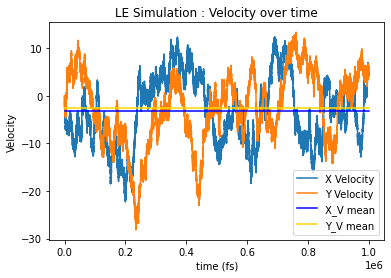

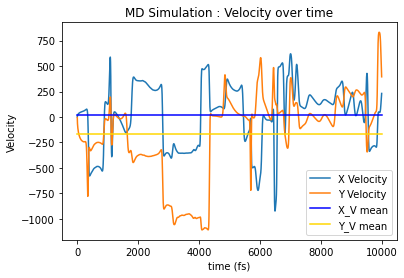

In [168]:
plot_vel(time_list_plot,check, check2, 'LE' )

v_x = Data_traj_list0[2,:]
v_y = Data_traj_list0[3,:]
plot_vel(time_list_plot0, v_x, v_y, 'MD' )

In [169]:
K= []
T = []
for i in trange(steps):
    K += [Kinetic(Data_traj_list, i)]
    T += [Kinetic(Data_traj_list, i)/k_b_mol]

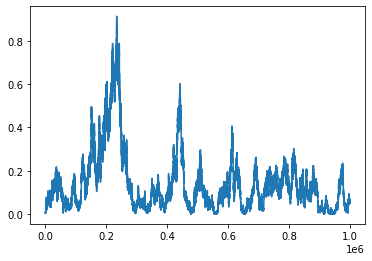

In [170]:
plt.plot(time_list_plot, T[:-1])

My integrator is probably wrong as my speed s too low, both compared to the MD simulation and to the Temperature calculated from the kinetic enery.

**Checking that the trajectories look correct**

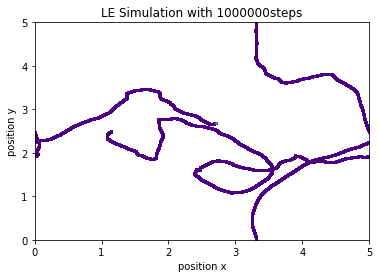

In [171]:
x, y =plot(Data_traj_list, 'LE')

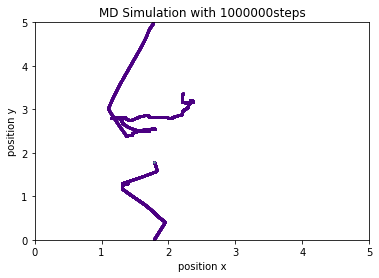

In [172]:
x, y =plot(Data_traj_list0, 'MD')

### Video

In [173]:
def creat_files(data_traj, steps):
    os.chdir("Image_storing_video")
    c = 'indigo'

    for t in trange (steps) :
        if t%5==0:
            plt.plot(data_traj[0,0],data_traj[1,0], marker='.', markersize='10',  linestyle = '-', alpha=0.3, color = c)
            plt.plot(data_traj[0,t],data_traj[1,t], marker='.', markersize='10',  linestyle = '-', color = c)

            #plt.show()
            plt.xlabel('position x')
            plt.ylabel('position y')
            plt.xlim(0,box[0])
            plt.ylim(0,box[1])
            plt.savefig("File%02d.png" % t)
    #plt.show()
    #plt.savefig("file.png")
    plt.close()



    Titles_graph1 = 'Example of one of the simulation of with' + str(steps) + 'steps'
    plt.title(Titles_graph1)
    os.chdir("../")

In [174]:
def creat_video():
    os.chdir("Image_storing_video")
    
    subprocess.call(['ffmpeg', '-framerate', '5', '-i', 'File%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', 'Contagion08.mp4'])
    #subprocess.call(['ffmpeg', '-framerate', '8', '-i', Titles_files, '-r', '30', '-pix_fmt', 'yuv420p', Filename])

    
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

    os.chdir("../")

In [175]:
'''
retval = os.getcwd()
print ("Current working directory %s" % retval)
creat_files(Data_traj_list0, steps0)
creat_video()
'''

'\nretval = os.getcwd()\nprint ("Current working directory %s" % retval)\ncreat_files(Data_traj_list0, steps0)\ncreat_video()\n'

In [176]:
#os.chdir("../")

## Task III: Determination of diffusion coefficient

**Diffusion coefficient :**
$$D=\frac{\Delta \vec{x}(t)^{2} }{4t}$$

with $\Delta \vec{x}(t) ^2 = (\vec{x}(t) − \vec{x}(t_{0}) )^2=\Delta x_{x}(t)^2 + \Delta x_{y}(t)^2$

In [177]:
def Diff_coef(t, Data_traj_list):
    #This function get_vect_r returns the conecting vection between two positions 
    # taking into account the periodic bounday conditions
    [Dlt_x, Dlt_y] = get_vect_r(Data_traj_list[0,0],Data_traj_list[1,0], Data_traj_list[0,t], Data_traj_list[1,t])
    
    D = (Dlt_x**2 + Dlt_y**2)/(4*t)
    Dltx = (Dlt_x**2 + Dlt_y**2)
    return D, Dltx

**Fricction coefficient**
$$ \Gamma = \frac{k_{b} T}{D}$$

In [178]:
def Fric_coef(D):
    Gamma = k_b * Temp / D
    return Gamma

**Calculation of D and $\Delta x^{2}$**

In [179]:
D_list = []
Dltx_list = []
Gamma_list = []

for t in trange(1,steps-1):
    D, Dltx = Diff_coef(t, Data_traj_list)
    D_list += [D]
    Dltx_list += [Dltx]
    Gamma_list += [Fric_coef(D)]

In [180]:
D_list0 = []
Dltx_list0 = []
Gamma_list0 = []

for t in trange(1,steps0-1):
    D0, Dltx0 = Diff_coef(t, Data_traj_list0)
    D_list0 += [D0]
    Dltx_list0 += [Dltx0]
    Gamma_list0 += [Fric_coef(D0)]

**Analysis of the evolution of $\Delta x^{2}$**

We can clearly see that for small values of t ( $<58000$ ),  $\Delta x^{2}$ is propotional to $t^{2}$. And after that the particle follows a diffusive behavior, therefore it should evolve linearly with t for large time scales. 

* Quadratic fit : $(t-10000)^{2} 4.16 *10^{-10}$

In [241]:
t_sqrd = []
for t in time_list_plot:
    t_sqrd += [(t-10000)**2 * 1.5/60000**2 ]

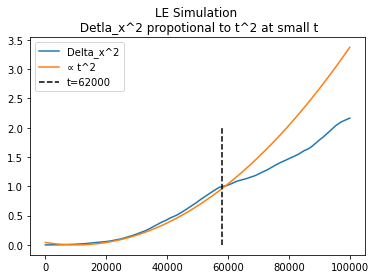

In [244]:
plt.plot(time_list_plot[:100000], Dltx_list[:100000], label ='Delta_x^2')
plt.plot(time_list_plot[:100000], t_sqrd[:100000], label = '∝ t^2')
plt.plot([58000,58000], [0,2],linestyle='--', color='Black', label='t=62000')
#plt.plot([22000,22000], [t_sqrd[0],t_sqrd[-1]],linestyle='--', color='Black', alpha = 0.3, label='t=22000')
plt.legend()
a=plt.title('LE Simulation \n Detla_x^2 propotional to t^2 at small t')

* Quadratic fit : $(t-150)^{2} /12*10^{-5}$

In [337]:
t_sqrd0 = []
for t in time_list_plot0:
    t_sqrd0 += [(t-150)**2 * 1/1200000 ]

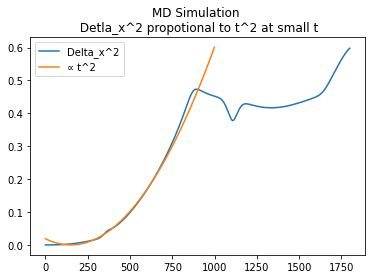

In [338]:
plt.plot(time_list_plot0[:1800], Dltx_list0[0:1800], label ='Delta_x^2')
plt.plot(time_list_plot0[:1000], t_sqrd0[:1000], label = '∝ t^2')
#plt.plot([62000,62000], [t_sqrd[0],t_sqrd[-1]],linestyle='--', color='Black', label='t=62000')
#plt.plot([22000,22000], [t_sqrd[0],t_sqrd[-1]],linestyle='--', color='Black', alpha = 0.3, label='t=22000')
plt.legend()
a=plt.title('MD Simulation \n Detla_x^2 propotional to t^2 at small t')

**Analysis of D**

We can see that beween 22000 and 62000 the evolution of D follows a linear evolution in function of t, which is consistant with an evolution proportionalto $t^{2}$ for $\Delta x^{2}$.

* Linear fit of t : $(t-16000) 10^{-11}$

For low values of t (22000 < t < 58000) D follows an evolution linear in t.  Which correspond to our the fact that $\Delta x^{2}$ is propotional to $t^{2}$ at low t.

In [215]:
t_lin = []
for t in time_list_plot:
    t_lin += [(t-16000) * 10e-11]

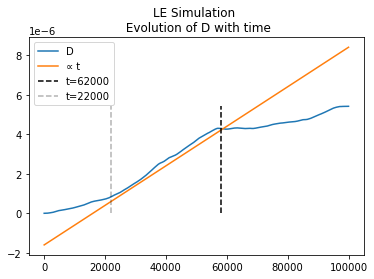

In [220]:
plt.plot(time_list_plot[:100000], D_list[:100000], label ='D')
plt.plot(time_list_plot[:100000], t_lin[:100000], label = '∝ t')
plt.plot([58000,58000], [min(D_list[:100000]),max(D_list[:100000])],linestyle='--', color='Black', label='t=62000')
plt.plot([22000,22000], [min(D_list[:100000]),max(D_list[:100000])],linestyle='--', color='Black', alpha=0.3, label='t=22000')
plt.legend()
a=plt.title('LE Simulation \n Evolution of D for small time')

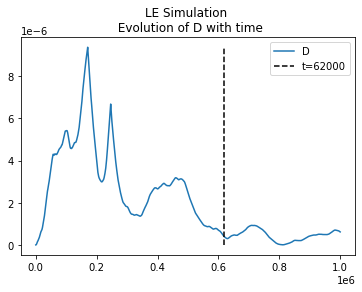

In [223]:
plt.plot(time_list_plot[1:], D_list, label ='D')
#plt.plot(time_list_plot[22000:62000], t_lin[22000:62000], label = '∝ t')
plt.plot([620000,620000], [min(D_list),max(D_list)],linestyle='--', color='Black', label='t=62000')
#plt.plot([22000,22000], [min(D_list),max(D_list)],linestyle='--', color='Black', alpha=0.3, label='t=22000')
plt.legend()
a=plt.title('LE Simulation \n Evolution of D with time')

**Interpretation of the results**

In [258]:
D_mean = np.mean(D_list[620000])*10e-3
print(D_mean, 'in m^2/s')

3.816757674740708e-09 in m^2/s


As expected $\Delta x^{2}$ is proportional to $t^{2}$ for small t and accordingly D is propotional to $t$. This time the initial velocity takes until it follows diffusive behavior seem to last until 58000fs.

D = 3.82 10^-9 m^2/s seems to be a reasonable result as for the diffusion for molecules dissolved in an aqueous solution, typical diffusion coefficients are in the range of $10^{-10}$ to $10^{-9} m^{2}/s$.

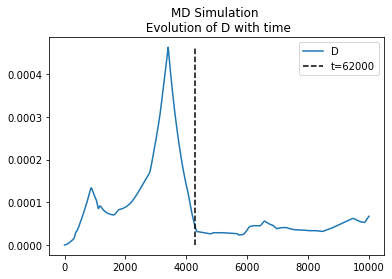

In [248]:
plt.plot(time_list_plot0[1:-1], D_list0, label ='D')
#plt.plot(time_list_plot[22000:62000], t_lin[22000:62000], label = '∝ t')
plt.plot([4300,4300], [min(D_list0),max(D_list0)],linestyle='--', color='Black', label='t=62000')
#plt.plot([22000,22000], [min(D_list),max(D_list)],linestyle='--', color='Black', alpha=0.3, label='t=62000')
plt.legend()
a=plt.title('MD Simulation \n Evolution of D with time')

In [254]:
D_mean0 = np.mean(D_list0[4300:])*10e-3
print(D_mean0, 'in m^2/s')

3.9119398931004695e-07 in m^2/s


$D_{0} = 3.91e-7 m^{2}/s$ seems also to be an acceptable result but would correspond more to a diffusion coefficient for a molecule in the gas phase. Which has a range $10^{-6}$ and $10^{-5}$ although it seems a bit too low for that. 

Second observation is that the velocity of the particle for in LE simulation is much lower the for the MD simulation. This might be a misktake in the LE intergrator, yeilding very low velocities or a wrong value of gamma given initially.
But we can still observe that in LE simulation we have low velocities, yeilding a lower D then for the MD one. Which in turns correspond to molocules in a liquid phase for LEs, with therefore lower velocities then in a gas phase described my the MD simulation (according to the value found of $D_0$.

We can see that in the MD simulation we reach the diffusive behavious quicker, which maybe due, once again, to higher velocities the in the LE simulation.

**Analysis of $\Gamma$**

$\Gamma$ is propotional to the inverse of D.

In [268]:
print('LE simulation : \n', 'D = ', D_mean, 'm^2/s \n', 'Gamma = ', Fric_coef(D_mean), 'Kg/s')
print()
print('MD simulation : \n', 'D0 = ', D_mean0, 'm^2/s \n', 'Gamma_0 = ', Fric_coef(D_mean0), 'Kg/s')

LE simulation : 
 D =  3.816757674740708e-09 m^2/s 
 Gamma =  1.0604216689693192e-12 Kg/s

MD simulation : 
 D0 =  3.9119398931004695e-07 m^2/s 
 Gamma_0 =  1.034620330092084e-14 Kg/s
